In [48]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 테스트 데이터 실행

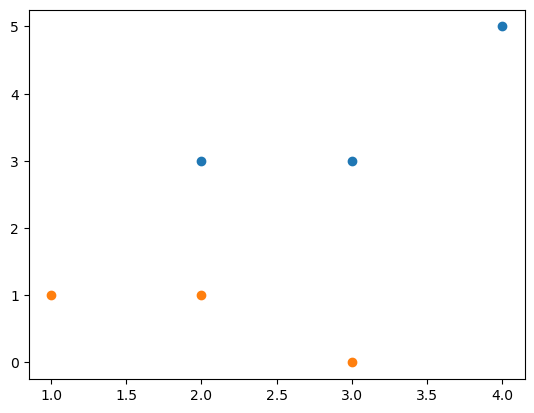

In [49]:
X = np.array([[2, 3], [3, 3], [4, 5], [1, 1], [2, 1], [3, 0]])
y = np.array([1, 1, 1, -1, -1, -1]) * 1.
C = 1.0

mask = (y == 1)
mask2 = (y != 1)

plt.scatter(X[mask, 0], X[mask, 1])
plt.scatter(X[mask2, 0], X[mask2, 1])
plt.show()

# 0. 문제 정의
![nn](temp/image.png)

# 1. 커널 함수 정의하기

In [50]:
from SVM import get_kernel
m, n = X.shape
K = np.zeros((m, m))

for i in range(m):
    for j in range(m):
        K[i, j] = get_kernel(X[i], X[j])

print(K)

[[13. 15. 23.  5.  7.  6.]
 [15. 18. 27.  6.  9.  9.]
 [23. 27. 41.  9. 13. 12.]
 [ 5.  6.  9.  2.  3.  3.]
 [ 7.  9. 13.  3.  5.  6.]
 [ 6.  9. 12.  3.  6.  9.]]


# 2. QP 이차식

![nn](temp/image2.png)
![nn](temp/image3.png)


## 2.1 QR 프로그램에 맞게 수식 수정하기

![nn](temp/image10.png)


In [51]:
diag_Y = np.diag(y.reshape(-1))
P = H =diag_Y @ K @ diag_Y
q = np.ones(m) * -1

## 2.2 제약조건 설정하기
<img src="temp/image5.png">

In [52]:
G = np.concatenate([np.diag(np.ones(m) * -1), np.diag(np.ones(m))], axis=0)
h = np.concatenate([np.zeros(m), np.ones(m) * C], axis=0)
A = y.reshape(1, -1)
b = np.zeros(1)

In [53]:
sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
alpha = sol['x']
alpha = np.array(alpha)
print(alpha.shape)

     pcost       dcost       gap    pres   dres
 0: -1.2455e+00 -1.0484e+01  4e+01  2e+00  1e-15
 1: -5.7926e-01 -5.7588e+00  7e+00  2e-01  1e-15
 2: -3.7386e-01 -9.9806e-01  7e-01  1e-02  2e-15
 3: -4.6676e-01 -5.4988e-01  9e-02  1e-03  7e-16
 4: -4.9650e-01 -5.0506e-01  9e-03  3e-05  6e-16
 5: -4.9952e-01 -5.0052e-01  1e-03  2e-16  8e-16
 6: -4.9993e-01 -5.0007e-01  1e-04  1e-16  6e-16
 7: -4.9999e-01 -5.0001e-01  2e-05  2e-16  6e-16
 8: -5.0000e-01 -5.0000e-01  3e-06  2e-16  6e-16
 9: -5.0000e-01 -5.0000e-01  4e-07  1e-16  5e-16
Optimal solution found.
(6, 1)


In [54]:
# zero_mask = (alpha > 0).reshape(-1)
zero_mask = ((alpha > 1e-4) & (alpha < C - 1e-4)).flatten()
print(zero_mask)
new_X, new_Y = X[zero_mask], y[zero_mask]

[ True  True False  True  True False]


## 2.3 문제 해결하기 -> alpha 얻음
<img src="temp/image12.png">

In [55]:
w = np.zeros(n)
w = (alpha[zero_mask] * new_Y.reshape(-1, 1) * new_X).sum(axis=0)
print(w)

[6.07524857e-04 9.99999993e-01]


## 2.3 문제 해결하기 -> alpha 얻음
<img src="temp/image11.png">

In [56]:
b = new_Y - np.dot(new_X, w)
b= b.mean()
b

-2.001215035073576

# 예측하기

In [57]:
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

print(predict(X, w, b))

[ 1.  1.  1. -1. -1. -1.]


# Sklearn VS Custom Model 비교

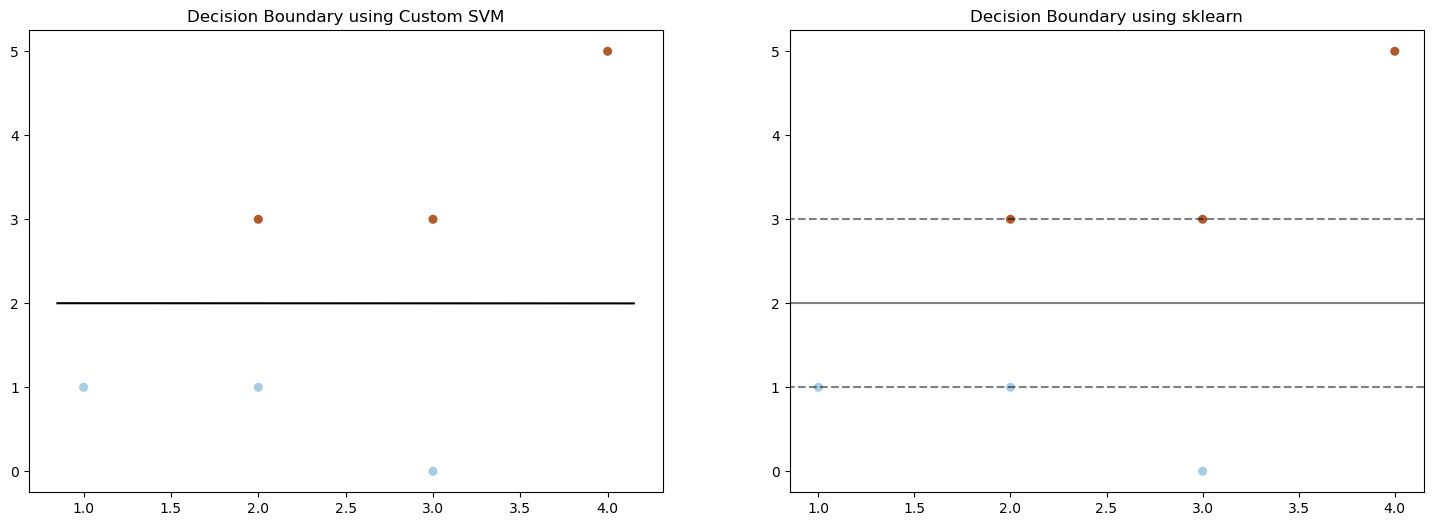

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

C = 1.0  # SVM 정규화 파라미터
model = svm.SVC(kernel='linear', C=C)
model.fit(X, y)

def decision_boundary(xx, w, b):
    return (-w[0] * xx - b) / w[1]


def plot_svm(X, y, w, b, model):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    axs[0].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = axs[0]
    xlim = ax.get_xlim()
    xx = np.linspace(xlim[0], xlim[1], 30)
    

    
    yy_cv = decision_boundary(xx, w, b)
    axs[0].plot(xx, yy_cv, 'k-', label='cvxopt decision boundary')
    axs[0].set_title('Decision Boundary using Custom SVM')

    axs[1].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = axs[1]
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    axs[1].set_title('Decision Boundary using sklearn')

    plt.show()
plot_svm(X, y, w, b, model)

# 위에 만든 SVM 클래스 만들기

In [66]:
from SVM import CustomSVM

In [67]:
custom_svm = CustomSVM(X, y, C=1)

In [68]:
custom_svm.fit()

     pcost       dcost       gap    pres   dres
 0: -1.2455e+00 -1.0484e+01  4e+01  2e+00  1e-15
 1: -5.7926e-01 -5.7588e+00  7e+00  2e-01  1e-15
 2: -3.7386e-01 -9.9806e-01  7e-01  1e-02  2e-15
 3: -4.6676e-01 -5.4988e-01  9e-02  1e-03  7e-16
 4: -4.9650e-01 -5.0506e-01  9e-03  3e-05  6e-16
 5: -4.9952e-01 -5.0052e-01  1e-03  2e-16  8e-16
 6: -4.9993e-01 -5.0007e-01  1e-04  1e-16  6e-16
 7: -4.9999e-01 -5.0001e-01  2e-05  2e-16  6e-16
 8: -5.0000e-01 -5.0000e-01  3e-06  2e-16  6e-16
 9: -5.0000e-01 -5.0000e-01  4e-07  1e-16  5e-16
Optimal solution found.


In [69]:
print("모델 bias : ", custom_svm.b)
print("모델 weight : ", custom_svm.w)

모델 bias :  -2.001215035073576
모델 weight :  [6.07524857e-04 9.99999993e-01]
